In [1]:
import pandas as pd
import numpy as np
import random

## Load data

The file is the output from the tracking+ID model. V3-V6 are the bounding box center, width + height. Class = 0 means lemur, class = 1 means feeding box. And the three letter names are the probabilities for each individual.

In [2]:
path = "/usr/users/vogg/monkey-tracking-in-the-wild/videos/lemurids_morelabels/a_e_1_220918_c2/"
with open(path + "results.txt", 'r') as file:
    lines = file.readlines()

# Process each line and create a list of DataFrames
dfs = []
max_columns = 18  # Set the maximum number of expected columns

for line in lines:
    # Split the line by comma and strip any leading/trailing whitespaces
    elements = [elem.strip() for elem in line.split(',')]

    # Fill missing values to match the maximum number of columns
    elements.extend([None] * (max_columns - len(elements)))

    # Create a DataFrame for the current line
    df_line = pd.DataFrame([elements])

    # Append the DataFrame to the list
    dfs.append(df_line)

# Concatenate the list of DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

df.columns = ["frame", "track", "V3", "V4", "V5", "V6", "conf", "class", "Cha", "Flo", "Gen", "Geo", "Her", "Rab", "Red", "Uns", "max", "ID"]
df['max'] = df[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max(axis=1)
df.head(5)

,frame,track,V3,V4,V5,V6,conf,class,Cha,Flo,Gen,Geo,Her,Rab,Red,Uns,max,ID
0,330,1,649.323486328125,371.85174560546875,45.94873046875,54.8421630859375,0.6088672876358032,0,0.03600765,0.039000943,0.014307591,0.011999648,0.0563227,0.019853406,0.0182269,0.80428106,0.0563227,7!
1,331,1,649.3265050406458,371.89936059368546,45.921507286993574,54.81011962890625,0.6012662649154663,0,0.034089778,0.038671114,0.0133426245,0.011330015,0.054052934,0.018081252,0.01771506,0.81271714,0.054052934,7!
2,332,1,649.3096430522887,371.86964560160334,45.86537150421678,54.74964398953025,0.5750808715820312,0,0.034250244,0.038826317,0.013586632,0.011384347,0.05519352,0.018456874,0.018195448,0.81010664,0.05519352,7!
3,333,1,649.2445600424588,371.7477986272375,45.97935908404192,54.898752082484194,0.5456086993217468,0,0.034588844,0.03833761,0.013594323,0.0114335045,0.05632437,0.018781314,0.01832001,0.80862,0.05632437,7!
4,334,1,649.6252742300908,371.8441935286095,45.754263719658596,54.68566046670077,0.5236036777496338,0,0.04198675,0.057379887,0.013659269,0.0138562415,0.06957749,0.029326629,0.01729523,0.7569185,0.06957749,7!


In [3]:
def are_boxes_overlapping(box1, box2):
    """
    Check if two bounding boxes overlap.

    Parameters:
    - box1, box2: Pandas Series representing bounding boxes with columns V3, V4, V5, V6.

    Returns:
    - True if boxes overlap, False otherwise.
    """
    overlap_x = max(0, min(box1['V3'] + box1['V5'], box2['V3'] + box2['V5']) - max(box1['V3'], box2['V3']))
    overlap_y = max(0, min(box1['V4'] + box1['V6'], box2['V4'] + box2['V6']) - max(box1['V4'], box2['V4']))

    area_overlap = overlap_x * overlap_y
    area_box1 = box1['V5'] * box1['V6']
    area_box2 = box2['V5'] * box2['V6']

    iou = area_overlap / (area_box1 + area_box2 - area_overlap)
    return iou > 0

def detect_overlapping_boxes(df):
    
    """
    Detect overlapping bounding boxes in a DataFrame.

    Parameters:
    - df: Pandas DataFrame with columns frame, track, V3, V4, V5, V6.

    Returns:
    - DataFrame with an additional column 'overlap' indicating whether boxes overlap.
    """
    df['overlap'] = False

    # Group by 'frame' column for efficient comparison within the same frame
    grouped_df = df[df['class'] == 0].groupby('frame')

    for frame, group in grouped_df:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                if are_boxes_overlapping(group.iloc[i], group.iloc[j]):
                    df.at[group.index[i], 'overlap'] = True
                    df.at[group.index[j], 'overlap'] = True

    return df

# Example usage:
# Assuming your DataFrame is named 'df'
result_df = detect_overlapping_boxes(df)
result_df.overlap.value_counts()


overlap
False    167675
Name: count, dtype: int64

In [15]:
grouped_df = result_df[result_df['class'] == 0].groupby('frame')['overlap'].any().reset_index()

# Rename the columns for clarity
grouped_df.columns = ['frame', 'overlap']
grouped_df

,frame,overlap


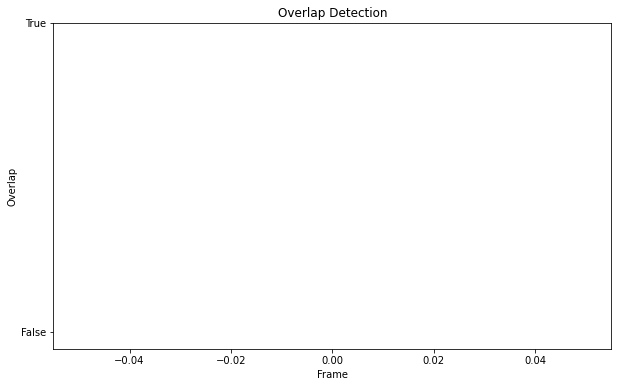

In [12]:
import matplotlib.pyplot as plt

# Assuming 'result_df' is your DataFrame with the 'overlap' column
plt.figure(figsize=(10, 6))

# Plot True values as red dots, and False values as blue dots
plt.scatter(grouped_df['frame'], grouped_df['overlap'], c=grouped_df['overlap'].map({True: 'red', False: 'blue'}),
            s= 1)

plt.title('Overlap Detection')
plt.xlabel('Frame')
plt.ylabel('Overlap')
plt.yticks([0, 1], ['False', 'True'])  # Set y-axis ticks to display 'False' and 'True'

plt.show()


In [106]:
grouped_df.sort_values(by="frame")

,frame,overlap
0,487,False
1,488,False
2,489,False
3,490,False
4,491,False
...,...,...
32055,36340,False
32056,36341,False
32057,36342,False
32058,36343,False


In [94]:
#This cell switches all the False to True, if there is a True within a distance of 10.
# This prevents from sampling from frames which are close to an overlap as we can expect there already being lemurs close
# even if they are not yet detected.
distance = 10

grouped_df = grouped_df.sort_values(by = "frame")
updated_df = grouped_df.copy()
min_frame = grouped_df.frame.min()
max_frame = grouped_df.frame.max()

for i, frame in enumerate(grouped_df.frame):
    if grouped_df.loc[i, 'overlap']:
        start_frame = max(min_frame, frame - distance)
        end_frame = min(max_frame, frame + distance + 1)
        updated_df.loc[(updated_df['frame'] >= start_frame) & (updated_df['frame'] < end_frame), 'overlap'] = True


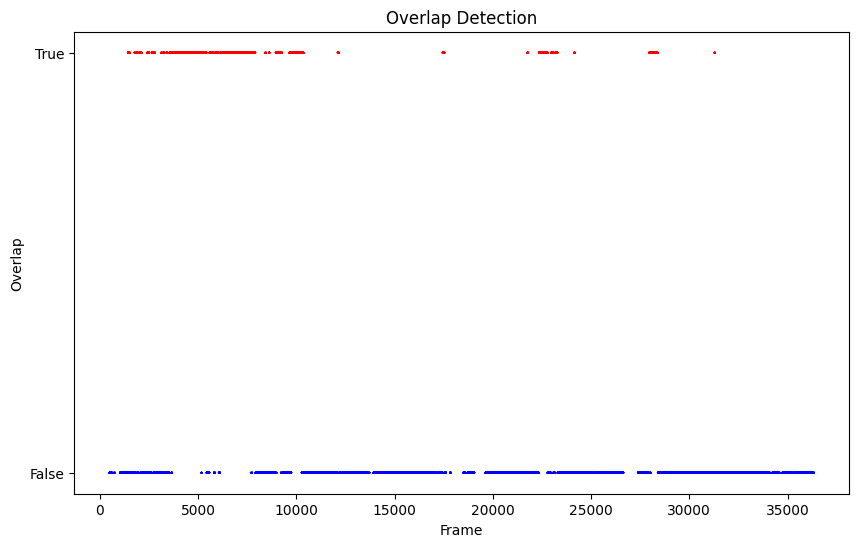

In [95]:

# Assuming 'result_df' is your DataFrame with the 'overlap' column
plt.figure(figsize=(10, 6))

# Plot True values as red dots, and False values as blue dots
plt.scatter(updated_df['frame'], updated_df['overlap'], c=updated_df['overlap'].map({True: 'red', False: 'blue'}),
            s= 0.1)

plt.title('Overlap Detection')
plt.xlabel('Frame')
plt.ylabel('Overlap')
plt.yticks([0, 1], ['False', 'True'])  # Set y-axis ticks to display 'False' and 'True'

plt.show()

In [102]:
nonempty_df = df.groupby('frame')['class'].apply(lambda x: (x == 0).any()).reset_index(name='has_detection')


In [115]:
nonempty_df.set_index("frame")
updated_df.set_index("frame")

,overlap
frame,
487,False
488,False
489,False
490,False
491,False
...,...
36340,False
36341,False
36342,False


In [121]:
final_df = nonempty_df.merge(updated_df, how = "left")

In [122]:
final_df

,frame,has_detection,overlap
0,307,False,NaN
1,308,False,NaN
2,309,False,NaN
3,310,False,NaN
4,311,False,NaN
...,...,...,...
36033,36340,True,False
36034,36341,True,False
36035,36342,True,False
36036,36343,True,False


In [199]:

filtered_df = df[df['class'] == 0]

# Group by track and calculate various statistics
result_df = pd.DataFrame()
result_df['track'] = filtered_df['track'].unique()

# Calculate the individual with the highest average probability across the track
result_df['highest_avg_individual'] = filtered_df.groupby('track')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].mean().idxmax(axis=1).values
result_df['highest_avg_probability'] = filtered_df.groupby('track')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].mean().max(axis=1).values

# Calculate the individual with the single highest probability value across the track
result_df['single_highest_individual'] = filtered_df.groupby('track')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max().idxmax(axis=1).values
result_df['single_highest_probability'] = filtered_df.groupby('track')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max().max(axis=1).values

# Calculate the individual with the highest number of times getting a probability value over 0.9 within the track
counts_over_thres = filtered_df[filtered_df['max'] > 0.8].groupby('track').apply(lambda x: x[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].idxmax(axis=1).value_counts().reset_index().rename(columns={'index': 'individual', 0: 'count'}) if not x.empty else pd.DataFrame({'individual': ['None'], 'count': [0]}))
counts_over_thres = counts_over_thres.reset_index(level=1, drop = True)
counts_over_thres = counts_over_thres.sort_values(by='count', ascending=False).groupby('track').first()

# Merge with result_df using an outer join
result_df = pd.merge(result_df, counts_over_thres, on='track', how='outer')

# Add total length of the track
result_df['track_length'] = filtered_df.groupby('track').size().values


result_df.to_csv("output.csv", index = False)


## Manual correction of track IDs

In [241]:
track_dict = {9: "Her", 13: "Gen", 16: "Red", 22: "Her", 27: "Geo", 33: "Red", 37: "Her", 51: "Geo", 53: "Rab", 54: "Rab", 57: "Geo", 59: "Her", 60: "Rab", 62: "Her", 
              71: "Rab", 78: "Red", 90: "Gen", 97: "Flo", 100: "Rab", 105: "Rab", 108: "Flo", 111: "Rab", 114: "Her", 115: "Her", 128: "Flo", 132: "Flo"}


lemur_vector = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']

output_df = df.copy()

# Iterate through the dictionary and update the DataFrame
for track, lemur_id in track_dict.items():
    # Get the index of lemur_id in the lemur_vector
    lemur_index = lemur_vector.index(lemur_id)

    # Filter rows with the specified track and class == 0
    mask = (df['track'] == track) & (df['class'] == 0)

    # Update the 'ID' column with the lemur_id index for the filtered rows
    output_df.loc[mask, 'ID'] = lemur_index

# For other entries, check the 'max' column and update 'ID' accordingly
max_threshold = 0.9
output_df['ID'] = output_df.apply(lambda row: row['ID'] if (str(row['ID']) == '0') or (str(row['ID']) == '1') or (str(row['ID']) == '2') or 
                    (str(row['ID']) == '3') or (str(row['ID']) == '4') or (str(row['ID']) == '5') or (str(row['ID']) == '6')  else 7, axis=1)


In [251]:
output_df.loc[output_df.frame == 3065]

,frame,track,V3,V4,V5,V6,conf,class,Cha,Flo,Gen,Geo,Her,Rab,Red,Uns,max,ID
4002,3065,22,925.416983,565.409969,450.167993,366.688280,0.991202,0,0.002677,0.010626,0.006891,0.067137,0.900708,0.000586,0.002337,0.009037,0.900708,4
4003,3065,24,1591.810389,645.847668,145.547939,115.723198,0.249838,0,0.064233,0.028277,0.018133,0.007215,0.037144,0.084870,0.026696,0.733432,0.084870,7
61435,3065,2,714.423315,625.042505,297.613467,278.632749,0.128258,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
61436,3065,4,1540.226958,670.462194,266.393545,242.005125,0.986319,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [248]:
#track_number = 115

sampled_frames = []

for track_number, id in track_dict.items():
    track_frame_list = df.groupby('track')['frame'].agg(list).reset_index()
    specific_track_frames = track_frame_list.loc[track_frame_list['track'] == track_number, 'frame'].iloc[0]

    eligible_frames = [frame for frame in specific_track_frames if final_df.loc[final_df['frame'] == frame, 'has_detection'].bool() 
                    and not final_df.loc[final_df['frame'] == frame, 'overlap'].bool()]

    # Assuming you have the list eligible_frames
    print(len(eligible_frames))
    # Sample 10 values from the list
    if len(eligible_frames) > 0:
        max_smpl = min(len(eligible_frames), 20)
        sampled_frames.append(random.sample(eligible_frames, max_smpl))

    # Display the sampled frames
sampled_frames =list(set(item for sublist in sampled_frames for item in sublist))
print(len(sampled_frames))


153
4499
10088
387
250
0
0
4
0
762
466
324
493
418
0
3210
1722
2263
311
238
1483
711
90
261
1627
409
420


In [252]:
import cv2
import os

base_path = "/Users/vogg/Documents/Videos/Lemurs/alpha/"
video_path = base_path + "a_e_1_220918_c1.mp4"


# Read the video
cap = cv2.VideoCapture(video_path)

# Create a directory to store the extracted frames
output_directory = 'experiment_name/images'
os.makedirs(output_directory, exist_ok=True)

# Loop through the sampled frames and extract/save them
for frame_number in sampled_frames:
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print(f"Error: Could not read frame {frame_number}.")
        continue

    # Save the frame as an image
    output_filename = f"{os.path.splitext(os.path.basename(video_path))[0]}_{frame_number}.jpg"
    output_path = os.path.join(output_directory, output_filename)
    cv2.imwrite(output_path, frame)

# Release the video capture object
cap.release()

print("Frames extracted and saved successfully.")


Frames extracted and saved successfully.


In [258]:
import os

# Assuming 'experiment_name' is the name of the experiment folder
experiment_name = 'experiment_name'


# Create a directory to store the labels with ids
output_labels_directory = os.path.join(experiment_name, 'labels_with_ids')
os.makedirs(output_labels_directory, exist_ok=True)

# Iterate through each sampled frame
for frame_number in sampled_frames:
    # Get the relevant information from the result_df DataFrame
    frame_info = output_df[output_df['frame'] == frame_number]

    # Create a text file for the current frame
    output_filename = f"{os.path.splitext(os.path.basename(video_path))[0]}_{frame_number}.txt"
    output_path = os.path.join(output_labels_directory, output_filename)

    # Write the information for each object in the frame to the text file
    with open(output_path, 'w') as file:
        for _, row in frame_info.iterrows():
            track_id = int(row['track'])
            x, y, w, h = (row['V3'] + row['V5']/2) / 1920, (row['V4'] + row['V6']/2) / 1080, row['V5'] / 1920, row['V6'] /1080
            cls = int(row['class'])
            id = int(row['ID'])

            # Write the line to the file
            file.write(f"{cls} {track_id} {round(x, 6)} {round(y,6)} {round(w,6)} {round(h,6)} {id}\n")

print("Label files created successfully.")


Label files created successfully.
